## SECTION I

Starting a Spark session \
Reading a file with Spark 

In [1]:
# conda install pyspark
# conda install pyarrow
# conda install -c conda-forge fastparquet

In [2]:
import pyspark
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('test') \
    .getOrCreate()

In [4]:
# !curl -o fhvhv_tripdata_2021-01.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2021-01.parquet

# Even though I was able to download the parquet file, I was not able to read it due to some attribute error. 
# So ended up taking the csv file from - https://github.com/DataTalksClub/nyc-tlc-data/releases/tag/fhvhv
# And then ran the following codes

In [5]:
!wc -l fhvhv_tripdata_2021-01.csv

11908469 fhvhv_tripdata_2021-01.csv


find: '/I': No such file or directory
find: '/N': No such file or directory
find: 'SoundMixer.exe': No such file or directory


In [6]:
df = spark.read \
    .option("header", "true") \
    .csv('fhvhv_tripdata_2021-01.csv')

In [7]:
df.head(5)

[Row(hvfhs_license_num='HV0003', dispatching_base_num='B02682', pickup_datetime='2021-01-01 00:33:44', dropoff_datetime='2021-01-01 00:49:07', PULocationID='230', DOLocationID='166', SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02682', pickup_datetime='2021-01-01 00:55:19', dropoff_datetime='2021-01-01 01:18:21', PULocationID='152', DOLocationID='167', SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02764', pickup_datetime='2021-01-01 00:23:56', dropoff_datetime='2021-01-01 00:38:05', PULocationID='233', DOLocationID='142', SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02764', pickup_datetime='2021-01-01 00:42:51', dropoff_datetime='2021-01-01 00:45:50', PULocationID='142', DOLocationID='143', SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02764', pickup_datetime='2021-01-01 00:48:14', dropoff_datetime='2021-01-01 01:08:42', PULocationID='143', DOLocationID='78', SR_Flag=None)]

In [8]:
df.schema

StructType(List(StructField(hvfhs_license_num,StringType,true),StructField(dispatching_base_num,StringType,true),StructField(pickup_datetime,StringType,true),StructField(dropoff_datetime,StringType,true),StructField(PULocationID,StringType,true),StructField(DOLocationID,StringType,true),StructField(SR_Flag,StringType,true)))

In [9]:
!head -n 1001 fhvhv_tripdata_2021-01.csv > head.csv

find: '/I': No such file or directory
find: '/N': No such file or directory
find: 'SoundMixer.exe': No such file or directory


In [10]:
import pandas as pd

In [11]:
df_pandas = pd.read_csv('head.csv')

In [12]:
df_pandas.dtypes

hvfhs_license_num        object
dispatching_base_num     object
pickup_datetime          object
dropoff_datetime         object
PULocationID              int64
DOLocationID              int64
SR_Flag                 float64
dtype: object

In [13]:
spark.createDataFrame(df_pandas).schema

StructType(List(StructField(hvfhs_license_num,StringType,true),StructField(dispatching_base_num,StringType,true),StructField(pickup_datetime,StringType,true),StructField(dropoff_datetime,StringType,true),StructField(PULocationID,LongType,true),StructField(DOLocationID,LongType,true),StructField(SR_Flag,DoubleType,true)))

In [14]:
# Or To directly infer the schema (instead of converting it into a pandas df and then get the schema)

# df = spark.read \
#     .option("header", "true") \
#     .option("inferSchema", "true") \
#     .csv('fhvhv_tripdata_2021-01.csv')

# df.printSchema()

## SECTION II

Enforcing a custom schema

In [15]:
from pyspark.sql import types

In [16]:
schema = types.StructType([
    types.StructField('hvfhs_license_num', types.StringType(), True),
    types.StructField('dispatching_base_num', types.StringType(), True),
    types.StructField('pickup_datetime', types.TimestampType(), True),
    types.StructField('dropoff_datetime', types.TimestampType(), True),
    types.StructField('PULocationID', types.IntegerType(), True),
    types.StructField('DOLocationID', types.IntegerType(), True),
    types.StructField('SR_Flag', types.StringType(), True)
])

In [17]:
df = spark.read \
    .option("header", "true") \
    .schema(schema) \
    .csv('fhvhv_tripdata_2021-01.csv')

In [18]:
df.head(5)

[Row(hvfhs_license_num='HV0003', dispatching_base_num='B02682', pickup_datetime=datetime.datetime(2021, 1, 1, 0, 33, 44), dropoff_datetime=datetime.datetime(2021, 1, 1, 0, 49, 7), PULocationID=230, DOLocationID=166, SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02682', pickup_datetime=datetime.datetime(2021, 1, 1, 0, 55, 19), dropoff_datetime=datetime.datetime(2021, 1, 1, 1, 18, 21), PULocationID=152, DOLocationID=167, SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02764', pickup_datetime=datetime.datetime(2021, 1, 1, 0, 23, 56), dropoff_datetime=datetime.datetime(2021, 1, 1, 0, 38, 5), PULocationID=233, DOLocationID=142, SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02764', pickup_datetime=datetime.datetime(2021, 1, 1, 0, 42, 51), dropoff_datetime=datetime.datetime(2021, 1, 1, 0, 45, 50), PULocationID=142, DOLocationID=143, SR_Flag=None),
 Row(hvfhs_license_num='HV0003', dispatching_base_num='B02764', pickup_dat

## SECTION III

Converting the single csv file into multiple Parquet files to enable all the spark clusters 

In [19]:
df = df.repartition(24)

In [20]:
# Had to download all the hadoop files from https://github.com/cdarlint/winutils/tree/master/hadoop-2.7.2/bin
# And replace the initially used hadoop files for this to work

df.write.parquet('fhvhv/2021/01/',  mode='overwrite')

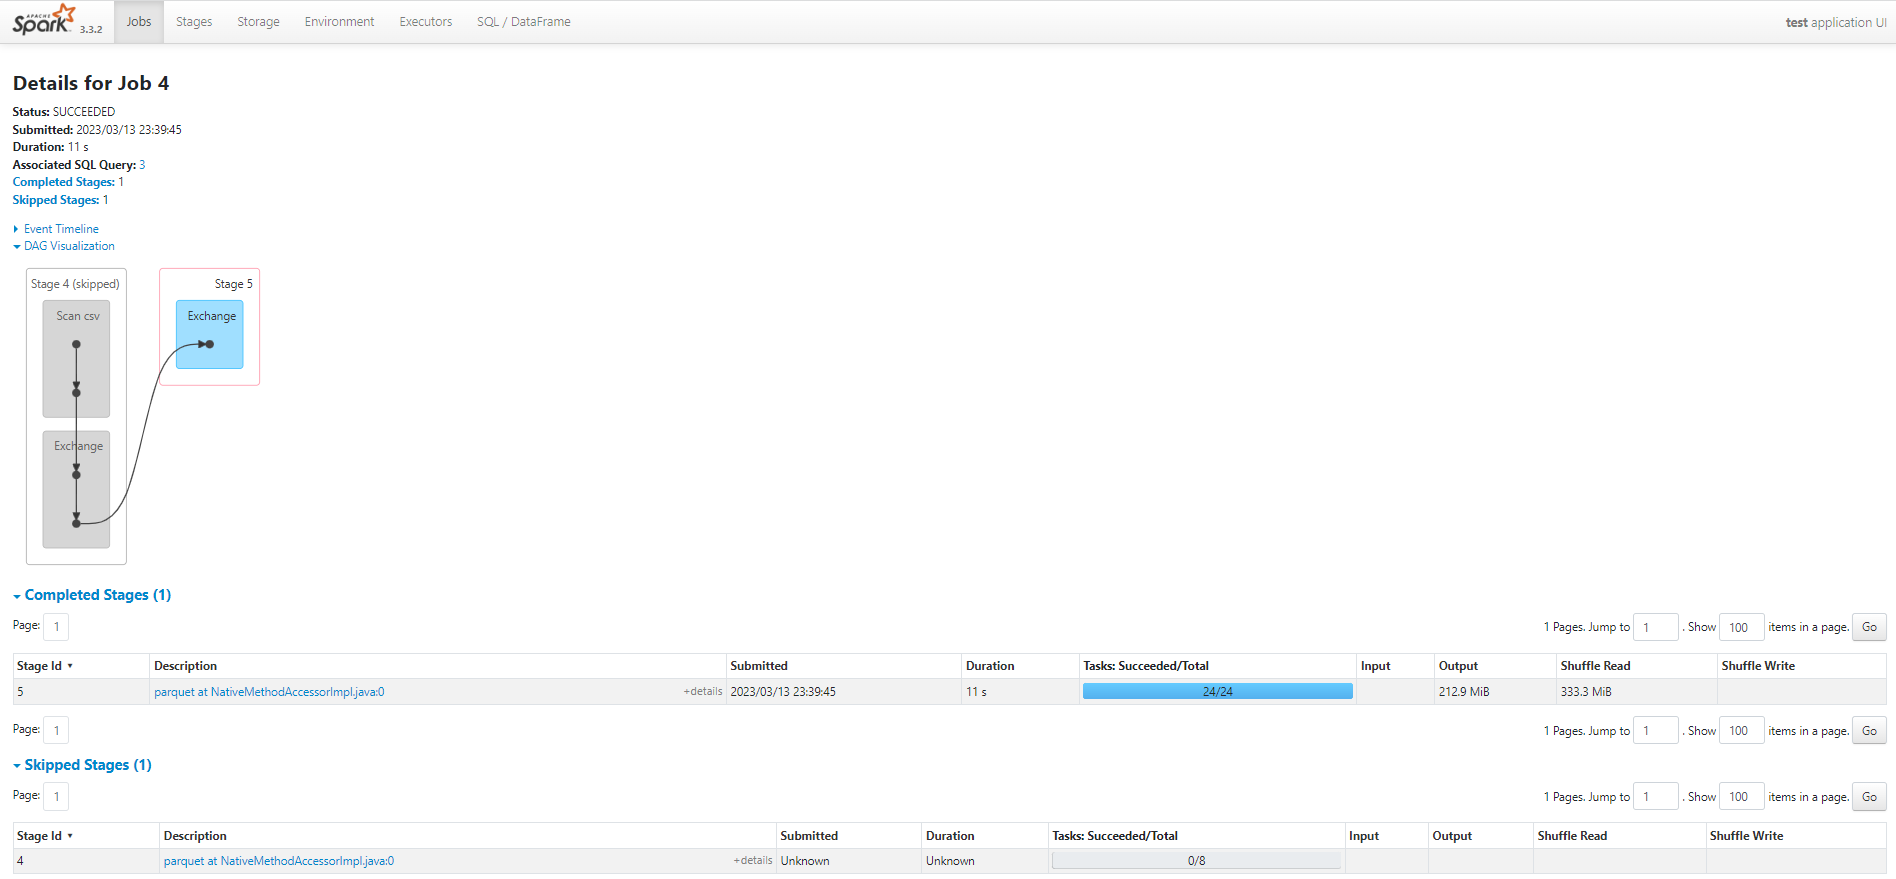

## SECTION IV

Creating Spark dataframes\
Using select command from spark

In [21]:
df = spark.read.parquet('fhvhv/2021/01/')

In [22]:
df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: string (nullable = true)



In [23]:
df.select('pickup_datetime', 'dropoff_datetime', 'PULocationID' , 'DOLocationID')

DataFrame[pickup_datetime: timestamp, dropoff_datetime: timestamp, PULocationID: int, DOLocationID: int]

In [24]:
df.select('pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID').filter(df.hvfhs_license_num == 'HV0003')

DataFrame[pickup_datetime: timestamp, dropoff_datetime: timestamp, PULocationID: int, DOLocationID: int]

## SECTION V

Functions and User Defined Functions (UDFs)

In [25]:
from pyspark.sql import functions as F

In [26]:
# Existing functions: Showing example - F.to_date()

df.withColumn('pickup_date', F.to_date(df.pickup_datetime)) \
  .withColumn('dropoff_date', F.to_date(df.dropoff_datetime)) \
  .select('pickup_date', 'dropoff_date', 'PULocationID', 'DOLocationID') \
  .show()

+-----------+------------+------------+------------+
|pickup_date|dropoff_date|PULocationID|DOLocationID|
+-----------+------------+------------+------------+
| 2021-01-04|  2021-01-04|         152|         193|
| 2021-01-03|  2021-01-03|         208|         213|
| 2021-01-04|  2021-01-04|         145|         202|
| 2021-01-02|  2021-01-02|          78|         169|
| 2021-01-02|  2021-01-02|          17|          73|
| 2021-01-01|  2021-01-01|         181|         107|
| 2021-01-02|  2021-01-02|         188|          72|
| 2021-01-01|  2021-01-01|          61|           4|
| 2021-01-03|  2021-01-03|         257|          54|
| 2021-01-04|  2021-01-04|          75|          75|
| 2021-01-01|  2021-01-02|         147|         175|
| 2021-01-05|  2021-01-05|          81|          81|
| 2021-01-01|  2021-01-01|          60|          60|
| 2021-01-04|  2021-01-04|         159|         212|
| 2021-01-01|  2021-01-01|         237|         151|
| 2021-01-03|  2021-01-03|         155|       

In [27]:
# User defined functions

def crazy_stuff(base_num):
    num = int(base_num[1:])
    if num % 7 == 0:
        return f's/{num:03x}'
    elif num % 3 == 0:
        return f'a/{num:03x}'
    else:
        return f'e/{num:03x}'

In [28]:
crazy_stuff('B02884')

's/b44'

In [29]:
# Creating a udf

crazy_stuff_udf = F.udf(crazy_stuff, returnType = types.StringType())

In [30]:
df.withColumn('pickup_date', F.to_date(df.pickup_datetime)) \
  .withColumn('dropoff_date', F.to_date(df.dropoff_datetime)) \
  .withColumn('base_id', crazy_stuff_udf(df.dispatching_base_num)) \
  .select('base_id', 'pickup_date', 'dropoff_date', 'PULocationID', 'DOLocationID') \
  .show()

+-------+-----------+------------+------------+------------+
|base_id|pickup_date|dropoff_date|PULocationID|DOLocationID|
+-------+-----------+------------+------------+------------+
|  e/b3b| 2021-01-04|  2021-01-04|         152|         193|
|  e/b14| 2021-01-03|  2021-01-03|         208|         213|
|  e/b30| 2021-01-04|  2021-01-04|         145|         202|
|  e/95b| 2021-01-02|  2021-01-02|          78|         169|
|  e/9ce| 2021-01-02|  2021-01-02|          17|          73|
|  e/a39| 2021-01-01|  2021-01-01|         181|         107|
|  e/b38| 2021-01-02|  2021-01-02|         188|          72|
|  s/b13| 2021-01-01|  2021-01-01|          61|           4|
|  a/b49| 2021-01-03|  2021-01-03|         257|          54|
|  e/b47| 2021-01-04|  2021-01-04|          75|          75|
|  e/b35| 2021-01-01|  2021-01-02|         147|         175|
|  e/b32| 2021-01-05|  2021-01-05|          81|          81|
|  e/b42| 2021-01-01|  2021-01-01|          60|          60|
|  e/b48| 2021-01-04|  2